<a href="https://colab.research.google.com/github/Samir-Doghmi/Deep_Learning/blob/main/3_CNN_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras import preprocessing
from keras.layers import Normalization
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
import os
from pathlib import Path
import PIL
from PIL import Image
import statistics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# seed initialization to get same results
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

# Upload

In [ ]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Import file in the virtual machine
t0 = time()
# Transfer zip dataset to the current virtual machine
copyfile('/content/gdrive/MyDrive/Project_DeepLearning/flower_photos_divided.zip', 'flower_photos_divided.zip') # fonte e dove copiarlo
# Extract files
zip = zipfile.ZipFile('flower_photos_divided.zip') #scompatta cartella zippata
zip.extractall() #invochiamo zip
zip.close() # necessario per accellerare le operazioni
print("File transfer completed in %0.3f seconds" % (time() - t0))

base_path = Path('flower_photos_divided/')

File transfer completed in 6.963 seconds


# Data



## Train and Validation

In [ ]:
# train dataset
train_dataset = keras.preprocessing.image_dataset_from_directory("flower_photos_divided/train", #assegniamo a variabile train dataset
                                                            image_size=(224,224), #dimesione standard   # ridimensionate alla stessa dimensione (stessa risoluzione). Per poter sfruttare il batch processing, le immagini vengono impilate in un unico tensore poiche alcuni livelli neurali funzionano in base ad una specifica cardinalità
                                                            batch_size=128,   # 128 immagini di input alla volta. più immagini, più l'apprendimento è stabile
                                                            label_mode='categorical',
                                                            #subset='training',
                                                            #validation_split = 0.2,
                                                            shuffle=True,# Data shuffling (randomization of the instances order) is fundamental to ensure that each minibatch is representative of the whole set of classes
                                                            seed=1)
# 800 file (80%) verrano utilizzati per l'addestramento, mentre 200 per il validation

Found 2935 files belonging to 5 classes.


In [ ]:
# validation dataset
val_dataset = keras.preprocessing.image_dataset_from_directory("flower_photos_divided/test", #assegniamo a variabile train dataset
                                                            image_size=(224,224), #dimesione standard   # ridimensionate alla stessa dimensione (stessa risoluzione). Per poter sfruttare il batch processing, le immagini vengono impilate in un unico tensore poiche alcuni livelli neurali funzionano in base ad una specifica cardinalità
                                                            batch_size=128,   # 128 immagini di input alla volta. più immagini, più l'apprendimento è stabile
                                                            label_mode='categorical',
                                                            #subset='validation',
                                                            #validation_split = 0.2,
                                                            shuffle=False,
                                                            seed=1)
# 800 file (80%) verrano utilizzati per l'addestramento, mentre 200 per il validation

Found 735 files belonging to 5 classes.


## Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal_and_vertical"),
     layers.RandomRotation(0.4),
     layers.RandomBrightness(factor= 0.4), # allowing the generator to randomly darken the image of 0.2 or 20%
     layers.RandomZoom(0.2),
     layers.RandomCrop(180,260),
     layers.Resizing(224,224),
     layers.Normalization()
    ]
)

# VGG16

VGG-16 is a neural network architecture designed by Visual Geometry Group.
with 13 convolutional layers and 3 fully connected layers for classification and detection tasks. Also  3x3 filter and a stride 1 that are in the same padding and maxpool layer of 2x2 filter of stride 2.

In [ ]:
#using  VGG16
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

In [ ]:
num_classes = 5

In [ ]:
# we set an early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

#we save only the best model
#checkpoint_filepath = 'gdrive/MyDrive/Project_DeepLearning/3_CNN_VGG16'
checkpoint_filepath = '/content/gdrive/MyDrive/Project_DeepLearning/3_CNN_VGG16 (1)'
mcp_save = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
VGG_model = tf.keras.applications.vgg16.VGG16(
    include_top=True,
    weights='imagenet',
    classifier_activation='softmax',
    input_tensor=tf.keras.layers.Input(shape=(224,224,3))
    #classes=num_classes
)

In [ ]:
VGG_model.trainable = False

In [ ]:
# Explicit input layer
inputs = keras.Input((224,224,3))
#x = inputs
x = data_augmentation(inputs)

x = VGG_model(x)

# New intermediate fully-connected layer + ReLU
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# New (final) fully-connected layer + SoftMax activation
#x = keras.layers.GlobalMaxPooling2D()(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

# Specialized model
VGG_model = keras.Model(inputs, outputs)

In [ ]:
print(VGG_model.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       7         
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense_18 (Dense)            (None, 512)               512512    
                                                                 
 dense_19 (Dense)            (None, 64)                32832     
                                                                 
 dense_20 (Dense)            (None, 5)                 325       
                                                                 
Total params: 138,903,220
Trainable params: 545,669
Non-tra

In [ ]:
# Compile the model for training
VGG_model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
# Model training
history = VGG_model.fit(train_dataset,
          epochs=80,
          validation_data=val_dataset,
          callbacks=[callback, mcp_save]);

Epoch 1/80
23/23 [==============================] - 20s 715ms/step - loss: 1.6506 - accuracy: 0.3847 - val_loss: 1.5346 - val_accuracy: 0.4259
Epoch 2/80
23/23 [==============================] - 17s 671ms/step - loss: 1.4927 - accuracy: 0.4433 - val_loss: 1.3586 - val_accuracy: 0.5211
Epoch 3/80
23/23 [==============================] - 19s 772ms/step - loss: 1.3654 - accuracy: 0.5015 - val_loss: 1.2511 - val_accuracy: 0.5973
Epoch 4/80
23/23 [==============================] - ETA: 0s - loss: 1.2756 - accuracy: 0.5557

23/23 [==============================] - 27s 1s/step - loss: 1.2756 - accuracy: 0.5557 - val_loss: 1.1602 - val_accuracy: 0.5973
Epoch 5/80
23/23 [==============================] - ETA: 0s - loss: 1.2072 - accuracy: 0.5659

23/23 [==============================] - 28s 1s/step - loss: 1.2072 - accuracy: 0.5659 - val_loss: 1.1143 - val_accuracy: 0.6068
Epoch 6/80
23/23 [==============================] - ETA: 0s - loss: 1.1628 - accuracy: 0.5884

23/23 [==============================] - 28s 1s/step - loss: 1.1628 - accuracy: 0.5884 - val_loss: 1.0843 - val_accuracy: 0.6109
Epoch 7/80
23/23 [==============================] - ETA: 0s - loss: 1.1157 - accuracy: 0.6058

23/23 [==============================] - 27s 1s/step - loss: 1.1157 - accuracy: 0.6058 - val_loss: 1.0700 - val_accuracy: 0.6150
Epoch 8/80
23/23 [==============================] - ETA: 0s - loss: 1.1086 - accuracy: 0.6037

23/23 [==============================] - 28s 1s/step - loss: 1.1086 - accuracy: 0.6037 - val_loss: 1.0557 - val_accuracy: 0.6109
Epoch 9/80
23/23 [==============================] - ETA: 0s - loss: 1.0812 - accuracy: 0.6034

23/23 [==============================] - 28s 1s/step - loss: 1.0812 - accuracy: 0.6034 - val_loss: 1.0413 - val_accuracy: 0.6231
Epoch 10/80
23/23 [==============================] - ETA: 0s - loss: 1.0695 - accuracy: 0.6136

23/23 [==============================] - 30s 1s/step - loss: 1.0695 - accuracy: 0.6136 - val_loss: 1.0349 - val_accuracy: 0.6150
Epoch 11/80
23/23 [==============================] - ETA: 0s - loss: 1.0460 - accuracy: 0.6330

23/23 [==============================] - 28s 1s/step - loss: 1.0460 - accuracy: 0.6330 - val_loss: 1.0257 - val_accuracy: 0.6177
Epoch 12/80
23/23 [==============================] - ETA: 0s - loss: 1.0513 - accuracy: 0.6147

23/23 [==============================] - 27s 1s/step - loss: 1.0513 - accuracy: 0.6147 - val_loss: 1.0176 - val_accuracy: 0.6136
Epoch 13/80
23/23 [==============================] - ETA: 0s - loss: 1.0532 - accuracy: 0.6198

23/23 [==============================] - 28s 1s/step - loss: 1.0532 - accuracy: 0.6198 - val_loss: 1.0130 - val_accuracy: 0.6299
Epoch 14/80
23/23 [==============================] - ETA: 0s - loss: 1.0478 - accuracy: 0.6164

23/23 [==============================] - 27s 1s/step - loss: 1.0478 - accuracy: 0.6164 - val_loss: 1.0111 - val_accuracy: 0.6109
Epoch 15/80
23/23 [==============================] - ETA: 0s - loss: 1.0372 - accuracy: 0.6218

23/23 [==============================] - 27s 1s/step - loss: 1.0372 - accuracy: 0.6218 - val_loss: 0.9987 - val_accuracy: 0.6340
Epoch 16/80
23/23 [==============================] - 19s 704ms/step - loss: 1.0100 - accuracy: 0.6276 - val_loss: 1.0059 - val_accuracy: 0.6109
Epoch 17/80
23/23 [==============================] - ETA: 0s - loss: 1.0014 - accuracy: 0.6348

23/23 [==============================] - 26s 1s/step - loss: 1.0014 - accuracy: 0.6348 - val_loss: 0.9970 - val_accuracy: 0.6286
Epoch 18/80
23/23 [==============================] - ETA: 0s - loss: 0.9898 - accuracy: 0.6419

23/23 [==============================] - 28s 1s/step - loss: 0.9898 - accuracy: 0.6419 - val_loss: 0.9892 - val_accuracy: 0.6381
Epoch 19/80
23/23 [==============================] - ETA: 0s - loss: 0.9824 - accuracy: 0.6440

23/23 [==============================] - 27s 1s/step - loss: 0.9824 - accuracy: 0.6440 - val_loss: 0.9877 - val_accuracy: 0.6245
Epoch 20/80
23/23 [==============================] - 17s 687ms/step - loss: 0.9886 - accuracy: 0.6388 - val_loss: 0.9991 - val_accuracy: 0.6463
Epoch 21/80
23/23 [==============================] - 17s 698ms/step - loss: 0.9994 - accuracy: 0.6395 - val_loss: 0.9900 - val_accuracy: 0.6354
Epoch 22/80
23/23 [==============================] - ETA: 0s - loss: 0.9752 - accuracy: 0.6549

23/23 [==============================] - 30s 1s/step - loss: 0.9752 - accuracy: 0.6549 - val_loss: 0.9845 - val_accuracy: 0.6422
Epoch 23/80
23/23 [==============================] - ETA: 0s - loss: 0.9814 - accuracy: 0.6422

23/23 [==============================] - 32s 1s/step - loss: 0.9814 - accuracy: 0.6422 - val_loss: 0.9750 - val_accuracy: 0.6367
Epoch 24/80
23/23 [==============================] - ETA: 0s - loss: 0.9743 - accuracy: 0.6504

23/23 [==============================] - 29s 1s/step - loss: 0.9743 - accuracy: 0.6504 - val_loss: 0.9662 - val_accuracy: 0.6395
Epoch 25/80
23/23 [==============================] - 20s 694ms/step - loss: 0.9652 - accuracy: 0.6453 - val_loss: 0.9672 - val_accuracy: 0.6422
Epoch 26/80
23/23 [==============================] - 17s 695ms/step - loss: 0.9738 - accuracy: 0.6477 - val_loss: 0.9702 - val_accuracy: 0.6354
Epoch 27/80
23/23 [==============================] - ETA: 0s - loss: 0.9692 - accuracy: 0.6416

23/23 [==============================] - 27s 1s/step - loss: 0.9692 - accuracy: 0.6416 - val_loss: 0.9655 - val_accuracy: 0.6476
Epoch 28/80
23/23 [==============================] - 18s 725ms/step - loss: 0.9547 - accuracy: 0.6412 - val_loss: 0.9765 - val_accuracy: 0.6259
Epoch 29/80
23/23 [==============================] - ETA: 0s - loss: 0.9573 - accuracy: 0.6610

23/23 [==============================] - 28s 1s/step - loss: 0.9573 - accuracy: 0.6610 - val_loss: 0.9547 - val_accuracy: 0.6463
Epoch 30/80
23/23 [==============================] - 19s 719ms/step - loss: 0.9637 - accuracy: 0.6504 - val_loss: 0.9586 - val_accuracy: 0.6531
Epoch 31/80
23/23 [==============================] - ETA: 0s - loss: 0.9445 - accuracy: 0.6566

23/23 [==============================] - 27s 1s/step - loss: 0.9445 - accuracy: 0.6566 - val_loss: 0.9479 - val_accuracy: 0.6626
Epoch 32/80
23/23 [==============================] - ETA: 0s - loss: 0.9390 - accuracy: 0.6535

23/23 [==============================] - 26s 1s/step - loss: 0.9390 - accuracy: 0.6535 - val_loss: 0.9464 - val_accuracy: 0.6721
Epoch 33/80
23/23 [==============================] - ETA: 0s - loss: 0.9510 - accuracy: 0.6532

23/23 [==============================] - 31s 1s/step - loss: 0.9510 - accuracy: 0.6532 - val_loss: 0.9416 - val_accuracy: 0.6707
Epoch 34/80
23/23 [==============================] - 18s 699ms/step - loss: 0.9613 - accuracy: 0.6491 - val_loss: 0.9625 - val_accuracy: 0.6599
Epoch 35/80
23/23 [==============================] - 20s 708ms/step - loss: 0.9443 - accuracy: 0.6583 - val_loss: 0.9434 - val_accuracy: 0.6571
Epoch 36/80
23/23 [==============================] - ETA: 0s - loss: 0.9209 - accuracy: 0.6698

23/23 [==============================] - 27s 1s/step - loss: 0.9209 - accuracy: 0.6698 - val_loss: 0.9380 - val_accuracy: 0.6789
Epoch 37/80
23/23 [==============================] - ETA: 0s - loss: 0.9338 - accuracy: 0.6457

23/23 [==============================] - 27s 1s/step - loss: 0.9338 - accuracy: 0.6457 - val_loss: 0.9372 - val_accuracy: 0.6762
Epoch 38/80
23/23 [==============================] - 18s 712ms/step - loss: 0.9250 - accuracy: 0.6654 - val_loss: 0.9615 - val_accuracy: 0.6558
Epoch 39/80
23/23 [==============================] - ETA: 0s - loss: 0.9107 - accuracy: 0.6627

23/23 [==============================] - 27s 1s/step - loss: 0.9107 - accuracy: 0.6627 - val_loss: 0.9364 - val_accuracy: 0.6571
Epoch 40/80
23/23 [==============================] - 18s 715ms/step - loss: 0.9210 - accuracy: 0.6712 - val_loss: 0.9413 - val_accuracy: 0.6503
Epoch 41/80
23/23 [==============================] - 19s 725ms/step - loss: 0.9266 - accuracy: 0.6528 - val_loss: 0.9514 - val_accuracy: 0.6367
Epoch 42/80
23/23 [==============================] - 18s 717ms/step - loss: 0.9103 - accuracy: 0.6784 - val_loss: 0.9477 - val_accuracy: 0.6667
Epoch 43/80
23/23 [==============================] - 18s 722ms/step - loss: 0.9122 - accuracy: 0.6651 - val_loss: 0.9368 - val_accuracy: 0.6707
Epoch 44/80
23/23 [==============================] - 18s 724ms/step - loss: 0.8905 - accuracy: 0.6767 - val_loss: 0.9588 - val_accuracy: 0.6667
Epoch 45/80
23/23 [==============================] - 18s 724ms/step - loss: 0.9041 - accuracy: 0.6675 - val_loss: 0.9450 - val_accuracy: 0.6612
Epoch 4

nota:   
1) importato solo il VGG, non sono stati agggiunti layer custom, veloce fino al 50%, poi lentissimo a salire fino al 55%
2) aggiunto un layer custom 512, parte gia dal 50%, arriva fino al 64% con due cicli e si ferma
3) aggiunto un layer da 64 dopo il 512: parte dal 54%, arriva al 64 in poco, poi sale cmq ma lentamente

In [ ]:
# To load the best model
VGG_model.load_weights(checkpoint_filepath)

## Validation of our Best Model

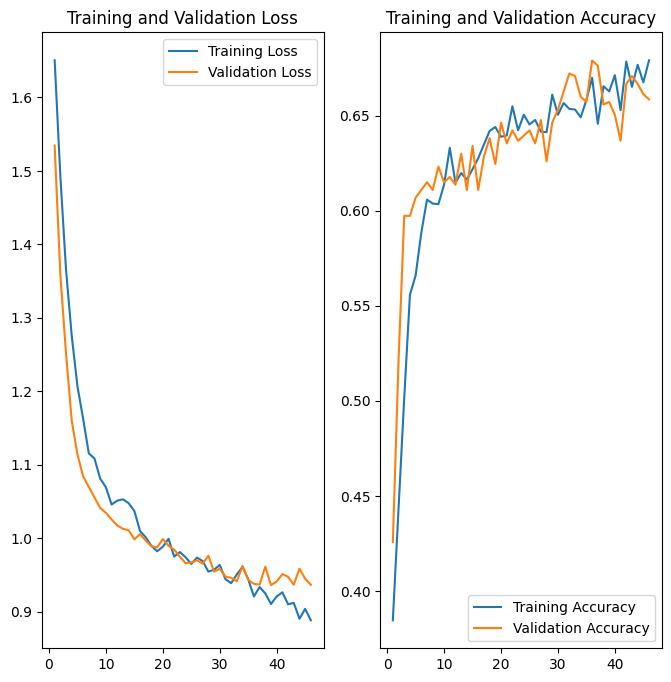

In [ ]:
# Visualization of the learning curves
acc = (history.history['accuracy'])
val_acc = (history.history['val_accuracy'])

loss = (history.history['loss'])
val_loss = (history.history['val_loss'])

num_epochs = len(history.epoch)
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Evaluation Best Model
score = VGG_model.evaluate(val_dataset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

6/6 [==============================] - 3s 467ms/step - loss: 0.9364 - accuracy: 0.6571
Test loss: 0.9363740682601929
Test accuracy: 0.6571428775787354


### Validation using prediction method

In [ ]:
# Inference
yc_pred = VGG_model.predict(val_dataset)
print('Prediction shape (probability distribution):', yc_pred.shape)

6/6 [==============================] - 3s 556ms/step
Prediction shape (probability distribution): (735, 5)


In [ ]:
# Selection of the highest-probability class for each test sample
y_pred = np.argmax(yc_pred, axis=1)

In [ ]:
# Retrieving the ground truth classes
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)

In [ ]:
y_test = np.argmax(yc_test, axis=1)

In [ ]:
accuracy_score(y_test, y_pred)

0.6571428571428571

In [ ]:
# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       127
           1       0.72      0.82      0.77       180
           2       0.54      0.66      0.59       128
           3       0.61      0.56      0.59       140
           4       0.64      0.51      0.57       160

    accuracy                           0.66       735
   macro avg       0.66      0.65      0.65       735
weighted avg       0.66      0.66      0.65       735



Confusion matrix:


Text(0, 0.5, 'Ground truth class')

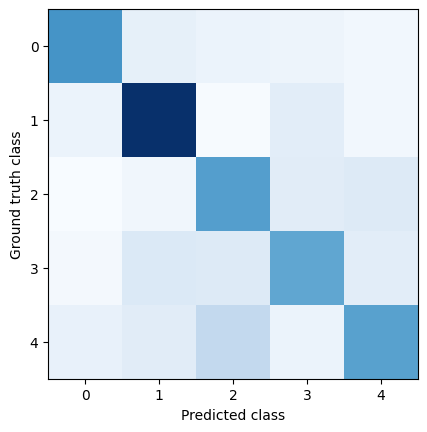

In [ ]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

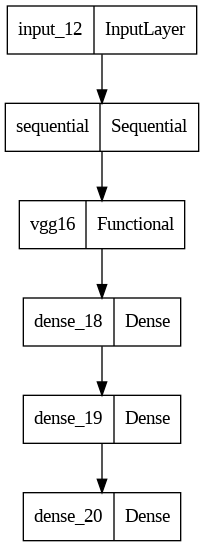

In [ ]:
keras.utils.plot_model(VGG_model)